In [1]:
import os
import local_pcangsd as lp
import lostruct
from skbio.stats.ordination import pcoa
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
input = "data/mytilus_test.beagle.gz" # input genotype likelihood file
store = "data/mytilus_test.zarr" # where to store the transformed file

Now we produce an on-disk format of the genotype likelihoods.

`local_pcangsd` functions work with an `xarray.Dataset` to avoid loading all genotype likelihoods into memory.

The Dataset in stored as a zarr file.

Run the following only once.

In [3]:
if not os.path.exists(store):
    lp.beagle_to_zarr(input, store, chunksize=10000)

In [4]:
ds = lp.load_dataset(store) # open the Dataset
ds

<xarray.Dataset>
Dimensions:              (variants: 194789, alleles: 2, samples: 218, genotypes: 3)
Dimensions without coordinates: variants, alleles, samples, genotypes
Data variables:
    allele               (variants, alleles) int8 dask.array<chunksize=(10000, 2), meta=np.ndarray>
    genotype_likelihood  (variants, samples, genotypes) float64 dask.array<chunksize=(10000, 218, 3), meta=np.ndarray>
    sample_id            (samples) object dask.array<chunksize=(218,), meta=np.ndarray>
    variant_contig       (variants) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_contig_name  (variants) object dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_position     (variants) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
Attributes:
    contigs:  ['CM029595.1_RagTag_pilon', 'CM029599.1_RagTag_pilon']

You can see that the dataset is similar to the sgkit internal format.

We now create windows variables, using sgkit functions internally.

In [5]:
ds = lp.window(ds, type='position', size=50000)
ds

<xarray.Dataset>
Dimensions:              (windows: 62, variants: 194789, alleles: 2, samples: 218, genotypes: 3)
Dimensions without coordinates: windows, variants, alleles, samples, genotypes
Data variables:
    window_contig        (windows) int64 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1
    window_start         (windows) int64 0 1128 2426 ... 186566 189427 190063
    window_stop          (windows) int64 1128 2426 3700 ... 189427 190063 194789
    allele               (variants, alleles) int8 dask.array<chunksize=(10000, 2), meta=np.ndarray>
    genotype_likelihood  (variants, samples, genotypes) float64 dask.array<chunksize=(10000, 218, 3), meta=np.ndarray>
    sample_id            (samples) object dask.array<chunksize=(218,), meta=np.ndarray>
    variant_contig       (variants) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_contig_name  (variants) object dask.array<chunksize=(10000,), meta=np.ndarray>
    variant_position     (variants) int64 dask.array<chunksize=(10000,), meta=np.ndarray>
Attributes:
    contigs:  ['CM029595.1_RagTag_pilon', 'CM029599.1_RagTag_pilon']

We compute PCAngsd on each window.

In [6]:
%%time
# pca_zarr_store = lp.pca_window(ds, zarr_store='data/mytilus_test_lp_results.zarr', k=5, num_workers=2)
pca_zarr_store = lp.pca_window(ds, zarr_store='data/mytilus_test_lp_results.zarr', k=5, scheduler="single-threaded")

/opt/conda/envs/local_pcangsd/lib/python3.9/site-packages/xarray/conventions.py:201: SerializationWarning: variable None has data in the form of a dask array with dtype=object, which means it is being loaded into memory to determine a data type that can be safely stored on disk. To avoid this, coerce this variable to a fixed-size dtype with astype() before saving it.
  warnings.warn(


CPU times: user 19min 9s, sys: 12min 25s, total: 31min 34s
Wall time: 4min 53s


In [6]:
ds_pca = xr.open_dataset('data/mytilus_test_lp_results.zarr', engine='zarr')
ds_pca

<xarray.Dataset>
Dimensions:         (windows: 62, samples_0: 218, samples_1: 218, samples: 218, PCs: 5)
Dimensions without coordinates: windows, samples_0, samples_1, samples, PCs
Data variables:
    C               (windows, samples_0, samples_1) float32 ...
    sample_id       (windows, samples) object ...
    total_variance  (windows) float32 ...
    vals            (windows, PCs) float32 ...
    vectors         (windows, PCs, samples) float32 ...
    window_contig   (windows) int64 ...
    window_start    (windows) int64 ...
    window_stop     (windows) int64 ...
Attributes:
    contigs:  ['CM029595.1_RagTag_pilon', 'CM029599.1_RagTag_pilon']

In [7]:
results = lp.to_lostruct(ds_pca)

In [8]:
print(f"Results on {results.shape[0]} windows")

Results on 62 windows


The output is formatted to be readable by `lostruct` functions.

In [9]:
pc_dists = lostruct.get_pc_dists(results)

In [10]:
mds = pcoa(pc_dists)

Text(0, 0.5, 'MDS 1')

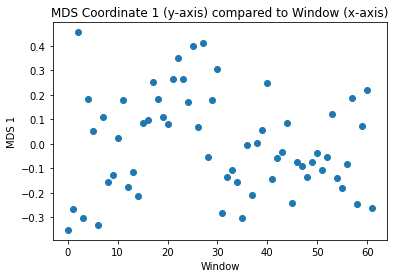

In [11]:
plt.figure()
plt.scatter(x=range(pc_dists.shape[0]), y=mds.samples["PC1"])
plt.title("MDS Coordinate 1 (y-axis) compared to Window (x-axis)")
plt.xlabel("Window")
plt.ylabel("MDS 1")

Text(0, 0.5, 'MDS 2')

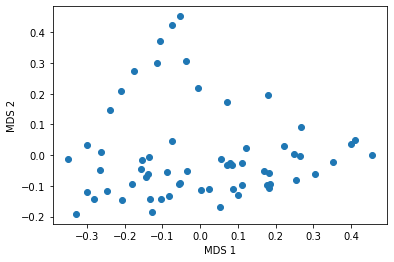

In [12]:
plt.figure()
plt.scatter(x=mds.samples["PC1"], y=mds.samples["PC2"])
plt.xlabel("MDS 1")
plt.ylabel("MDS 2")